Train shape: (9864, 58)
Test shape: (2466, 58)
Class distribution (train):
Revenue
False    0.845296
True     0.154704
Name: proportion, dtype: float64

Baseline Decision Tree 
Baseline tree depth: 42
Baseline number of leaves: 1741

Baseline performance (test) 
Accuracy: 0.7623682076236821
Precision: 0.23711340206185566
Recall: 0.24083769633507854
F1: 0.23896103896103896
ROC-AUC: 0.5494015736953703
PR-AUC: 0.17470519669874407

Confusion matrix:
 [[1788  296]
 [ 290   92]]

Classification report:
               precision    recall  f1-score   support

       False       0.86      0.86      0.86      2084
        True       0.24      0.24      0.24       382

    accuracy                           0.76      2466
   macro avg       0.55      0.55      0.55      2466
weighted avg       0.76      0.76      0.76      2466


=== Tuned Decision Tree (pre-pruning) ===
Best params (GridSearchCV): {'class_weight': 'balanced', 'max_depth': 9, 'min_samples_leaf': 20, 'min_samples_split': 50}
Best 

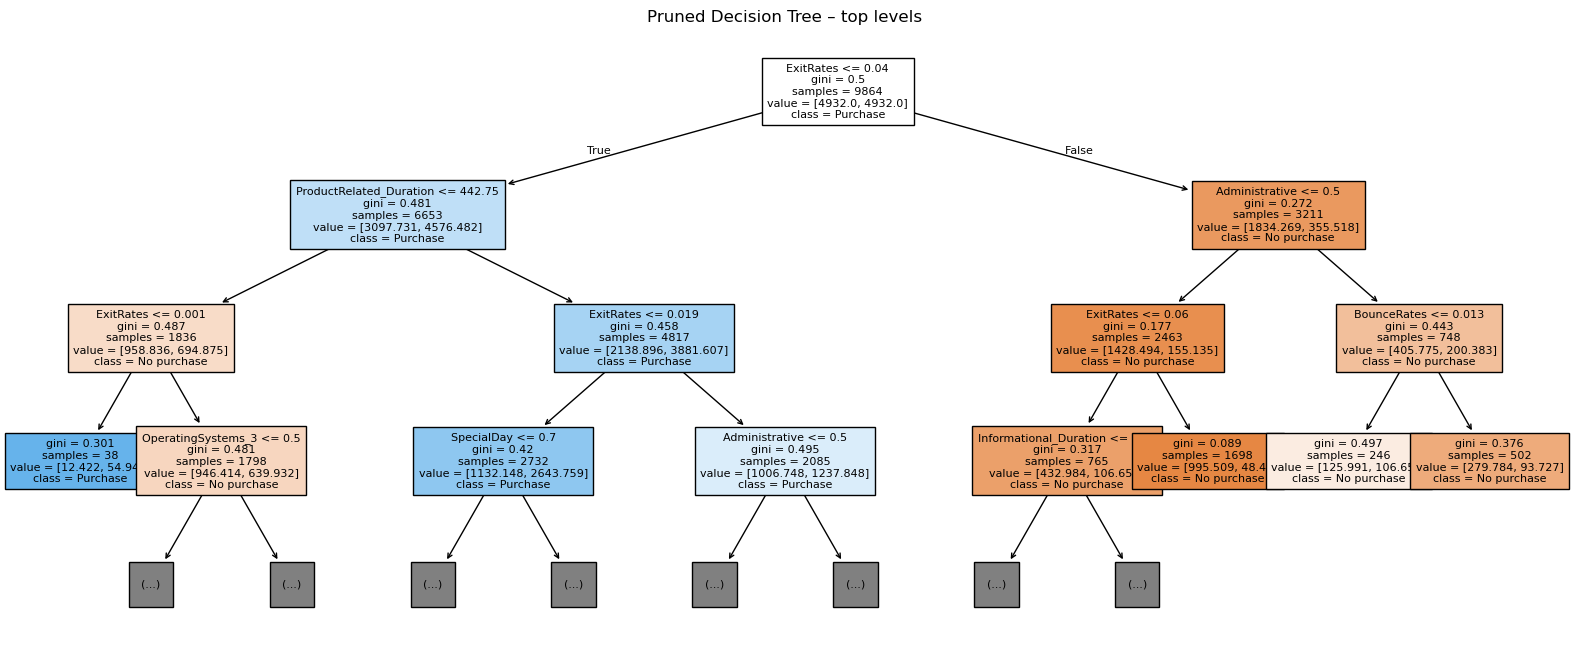

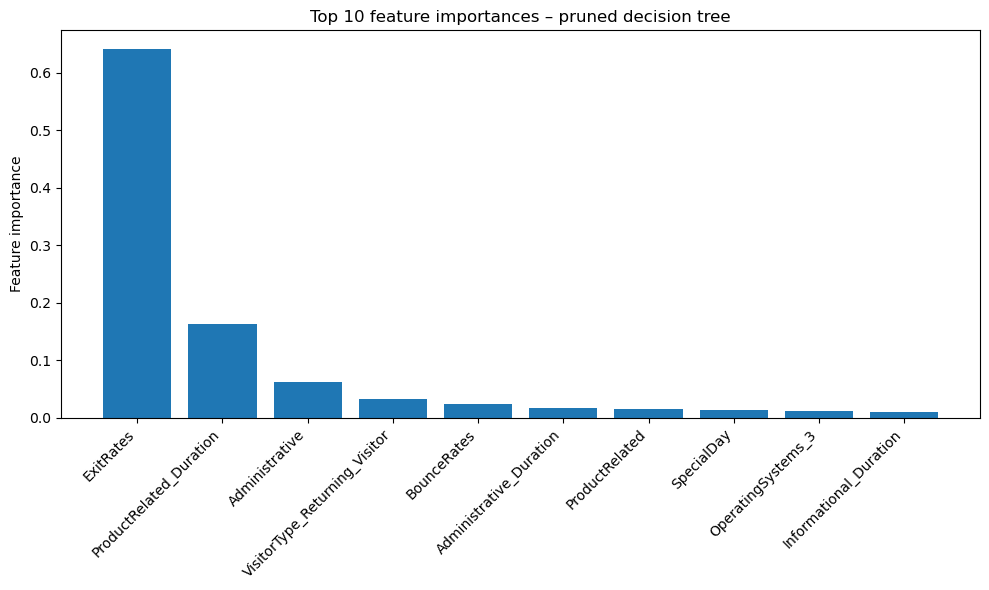

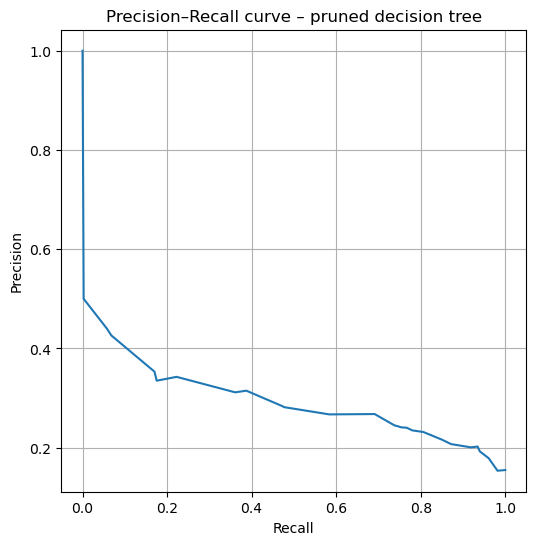

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    precision_recall_curve
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score



X_train = pd.read_csv("../Data/Processed/X_train.csv")
X_test  = pd.read_csv("../Data/Processed/X_test.csv")
y_train = pd.read_csv("../Data/Processed/y_train.csv").squeeze()
y_test  = pd.read_csv("../Data/Processed/y_test.csv").squeeze()


X = X_train.copy()
y = y_train.copy()

print("Train shape:", X.shape)
print("Test shape:", X_test.shape)
print("Class distribution (train):")
print(y.value_counts(normalize=True))




dt_baseline = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",   # handle class imbalance
    max_depth=None             
)

dt_baseline.fit(X, y)

print("\nBaseline Decision Tree ")
print("Baseline tree depth:", dt_baseline.get_depth())
print("Baseline number of leaves:", dt_baseline.get_n_leaves())

y_pred_base = dt_baseline.predict(X_test)
y_proba_base = dt_baseline.predict_proba(X_test)[:, 1]

print("\nBaseline performance (test) ")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("Precision:", precision_score(y_test, y_pred_base))
print("Recall:", recall_score(y_test, y_pred_base))
print("F1:", f1_score(y_test, y_pred_base))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_base))
print("PR-AUC:", average_precision_score(y_test, y_proba_base))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_base))
print("\nClassification report:\n", classification_report(y_test, y_pred_base))

# 3. Hyperparameter tuning (pre-pruning)- Goal: better PR-AUC & less overfitting

param_grid_dt = {
    "max_depth": [3, 5, 7, 9, 12],
    "min_samples_split": [2, 10, 20, 50],
    "min_samples_leaf": [1, 5, 10, 20],
    "class_weight": [None, "balanced"]
}

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring="average_precision",  
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid_dt.fit(X, y)

print("\n=== Tuned Decision Tree (pre-pruning) ===")
print("Best params (GridSearchCV):", grid_dt.best_params_)
print("Best CV PR-AUC:", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

print("Tuned tree depth:", best_dt.get_depth())
print("Tuned number of leaves:", best_dt.get_n_leaves())

# Evaluate tuned tree on test set
y_pred_best = best_dt.predict(X_test)
y_proba_best = best_dt.predict_proba(X_test)[:, 1]

print("Tuned Decision Tree performance (test)")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall:", recall_score(y_test, y_pred_best))
print("F1:", f1_score(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))
print("PR-AUC:", average_precision_score(y_test, y_proba_best))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification report:\n", classification_report(y_test, y_pred_best))


# Post-pruning with cost-complexity pruning (ccp_alpha) 

print("\n=== Cost-complexity pruning (post-pruning) ===")

# Compute pruning path on training data based on the tuned tree
path = best_dt.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas

print(f"Number of candidate alphas: {len(ccp_alphas)}")

pruned_cv_scores = []

for alpha in ccp_alphas:
    pruned = DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced",
        ccp_alpha=alpha
    )
    scores = cross_val_score(
        pruned,
        X,
        y,
        cv=cv,
        scoring="average_precision",
        n_jobs=-1
    )
    pruned_cv_scores.append(scores.mean())

best_alpha_index = int(np.argmax(pruned_cv_scores))
best_alpha = ccp_alphas[best_alpha_index]

print("Best alpha (ccp_alpha):", best_alpha)
print("Best CV PR-AUC with pruning:", pruned_cv_scores[best_alpha_index])

# Train final pruned tree on full training set
pruned_dt = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced",
    ccp_alpha=best_alpha
)
pruned_dt.fit(X, y)

print("Pruned tree depth:", pruned_dt.get_depth())
print("Pruned number of leaves:", pruned_dt.get_n_leaves())

# Evaluate pruned tree on test set
y_pred_pruned = pruned_dt.predict(X_test)
y_proba_pruned = pruned_dt.predict_proba(X_test)[:, 1]

print("Post-pruned Decision Tree performance (test)")
print("Accuracy:", accuracy_score(y_test, y_pred_pruned))
print("Precision:", precision_score(y_test, y_pred_pruned))
print("Recall:", recall_score(y_test, y_pred_pruned))
print("F1:", f1_score(y_test, y_pred_pruned))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_pruned))
print("PR-AUC:", average_precision_score(y_test, y_proba_pruned))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_pruned))
print("\nClassification report:\n", classification_report(y_test, y_pred_pruned))




plt.figure(figsize=(20, 8))
tree.plot_tree(
    pruned_dt,
    feature_names=X.columns,
    class_names=["No purchase", "Purchase"],
    filled=True,
    max_depth=3,      
    fontsize=8
)
plt.title("Pruned Decision Tree – top levels")
plt.show()

# Feature importance plot (pruned tree)
importances = pruned_dt.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10  

plt.figure(figsize=(10, 6))
plt.bar(range(top_n), importances[indices][:top_n])
plt.xticks(range(top_n), X.columns[indices][:top_n], rotation=45, ha="right")
plt.ylabel("Feature importance")
plt.title("Top 10 feature importances – pruned decision tree")
plt.tight_layout()
plt.show()

# Precision–Recall curve for pruned tree
prec, rec, thresholds = precision_recall_curve(y_test, y_proba_pruned)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve – pruned decision tree")
plt.grid(True)
plt.show()

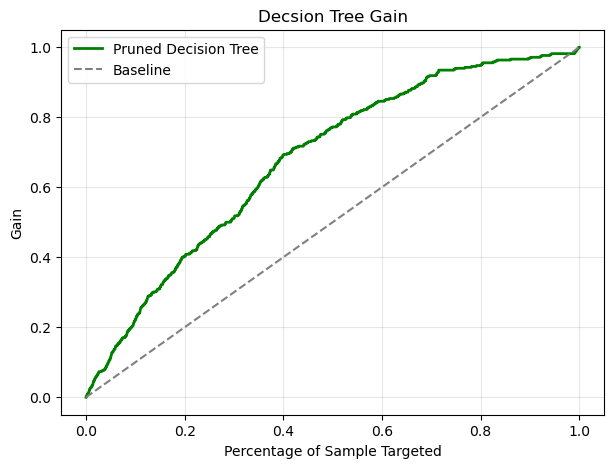

Exception ignored in: <function ResourceTracker.__del__ at 0x102390cc0>
Traceback (most recent call last):
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x107c40cc0>
Traceback (most recent call last):
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/Users/rathsusan/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exceptio

In [8]:
sorted_indices = np.argsort(y_proba_pruned)[::-1]
y_test_sorted = np.array(y_test)[sorted_indices]

gain = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
percentages = np.arange(1, len(gain) + 1) / len(gain)

gain = np.insert(gain, 0, 0)
percentages = np.insert(percentages, 0, 0)

plt.figure(figsize=(7, 5))
plt.plot(percentages, gain, label='Pruned Decision Tree', color='green', lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label='Baseline')

plt.title("Decsion Tree Gain")
plt.xlabel("Percentage of Sample Targeted")
plt.ylabel("Gain")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()